# Tree building P19003-11

Here I run the model for P19003-11 which has NPM1 and IDH2 nuclear mutations as well as a mitochondrial variant. This patient in karyotype normal

## Import packages 



<br>



In [1]:
# Import packages
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import itertools
import os
import pickle
import collections


import dill

import time
from datetime import datetime
from timeit import default_timer as timer
from datetime import timedelta

import scipy
from scipy.stats import betabinom

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam, AdagradRMSProp, MultiStepLR
from torch.distributions import constraints
pyro.set_rng_seed(100)

# import helper functions and tree class form source code files (present in the same directory)
from helper_functions import *

In [5]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
patient = "P19003_1"

## Load data

In [11]:
# load data from patient W
with open("data/"+patient+".json") as f:
    data = json.load(f)
       
# add type of mutations: 0 = CNV, 1 = nuclear, 2 = mitochondrial
data["type"] = np.array([1, 1, 2])


In [12]:
data['colnames']

['NPM1', 'IDH2', 'X11426.G.A']

# Build tree W

Here I heuristically build the clonal hierarchy of patient K

## Create tree class 


In [13]:
data_svi = {"M": torch.Tensor(data["M"]),
         "N": torch.Tensor(data["N"]),
         "mut_type": torch.Tensor([1,1,2]),
         "h_alpha": torch.Tensor([1000.0, 1000.0,1]),
         "h_beta": torch.Tensor([1000.0,1000.0, 1]),
         "af_alpha": torch.Tensor([[1, 14, 5], [9, 74,106]]),
         "af_beta": torch.Tensor([[9, 177, 970], [3,86, 583]]),
         "r_cnv": torch.Tensor([0,0,0]),
         "names": data["colnames"],
         "barcodes": data["cell_barcode"], 
         "umapx": data["umapx"], 
         "umapy": data["umapy"],
         "class_af": True, 
         "class_assign": torch.cuda.IntTensor(data["myeloid"]),
         "class_names": ["Tcells", "Tumor_cells"],
         "cnv_celltype": False,                                         
         "celltype": [],
         "celltype_names": [],
         "cnv_ct_mean": [],
         "cnv_ct_sd": []}


In [14]:
t = tree(patient, data_svi)
t.sel_mutation(initial = True)

tensor([2, 0])

In [15]:
t.names

['NPM1', 'IDH2', 'X11426.G.A']

## Initial tree with NPM1 & mt:11426G>A

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 1m 40s
Model fit to tree 1 in 1m 40s
Model fit to tree 2 in 1m 40s
Model fit to tree 3 in 1m 41s
Trees [0, 1, 3] selected for mutations ['X11426.G.A', 'NPM1']
tensor([[0., 0.],
        [1., 0.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 1.],
        [1., 1.]])
tensor([[0., 0.],
        [1., 1.]])
Total run time 0h 6m 43s


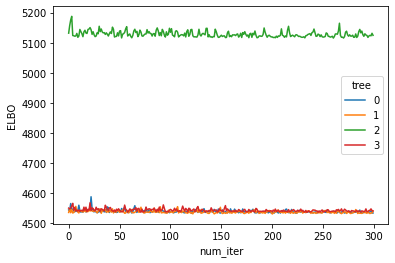

In [22]:
t.select_tree(num_iter = 500, init = 200)

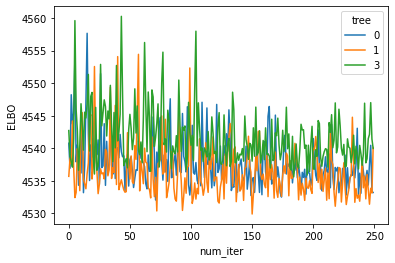

In [23]:
t.print_elbo(num_iter = 500, init = 250, include = [0,1,3])

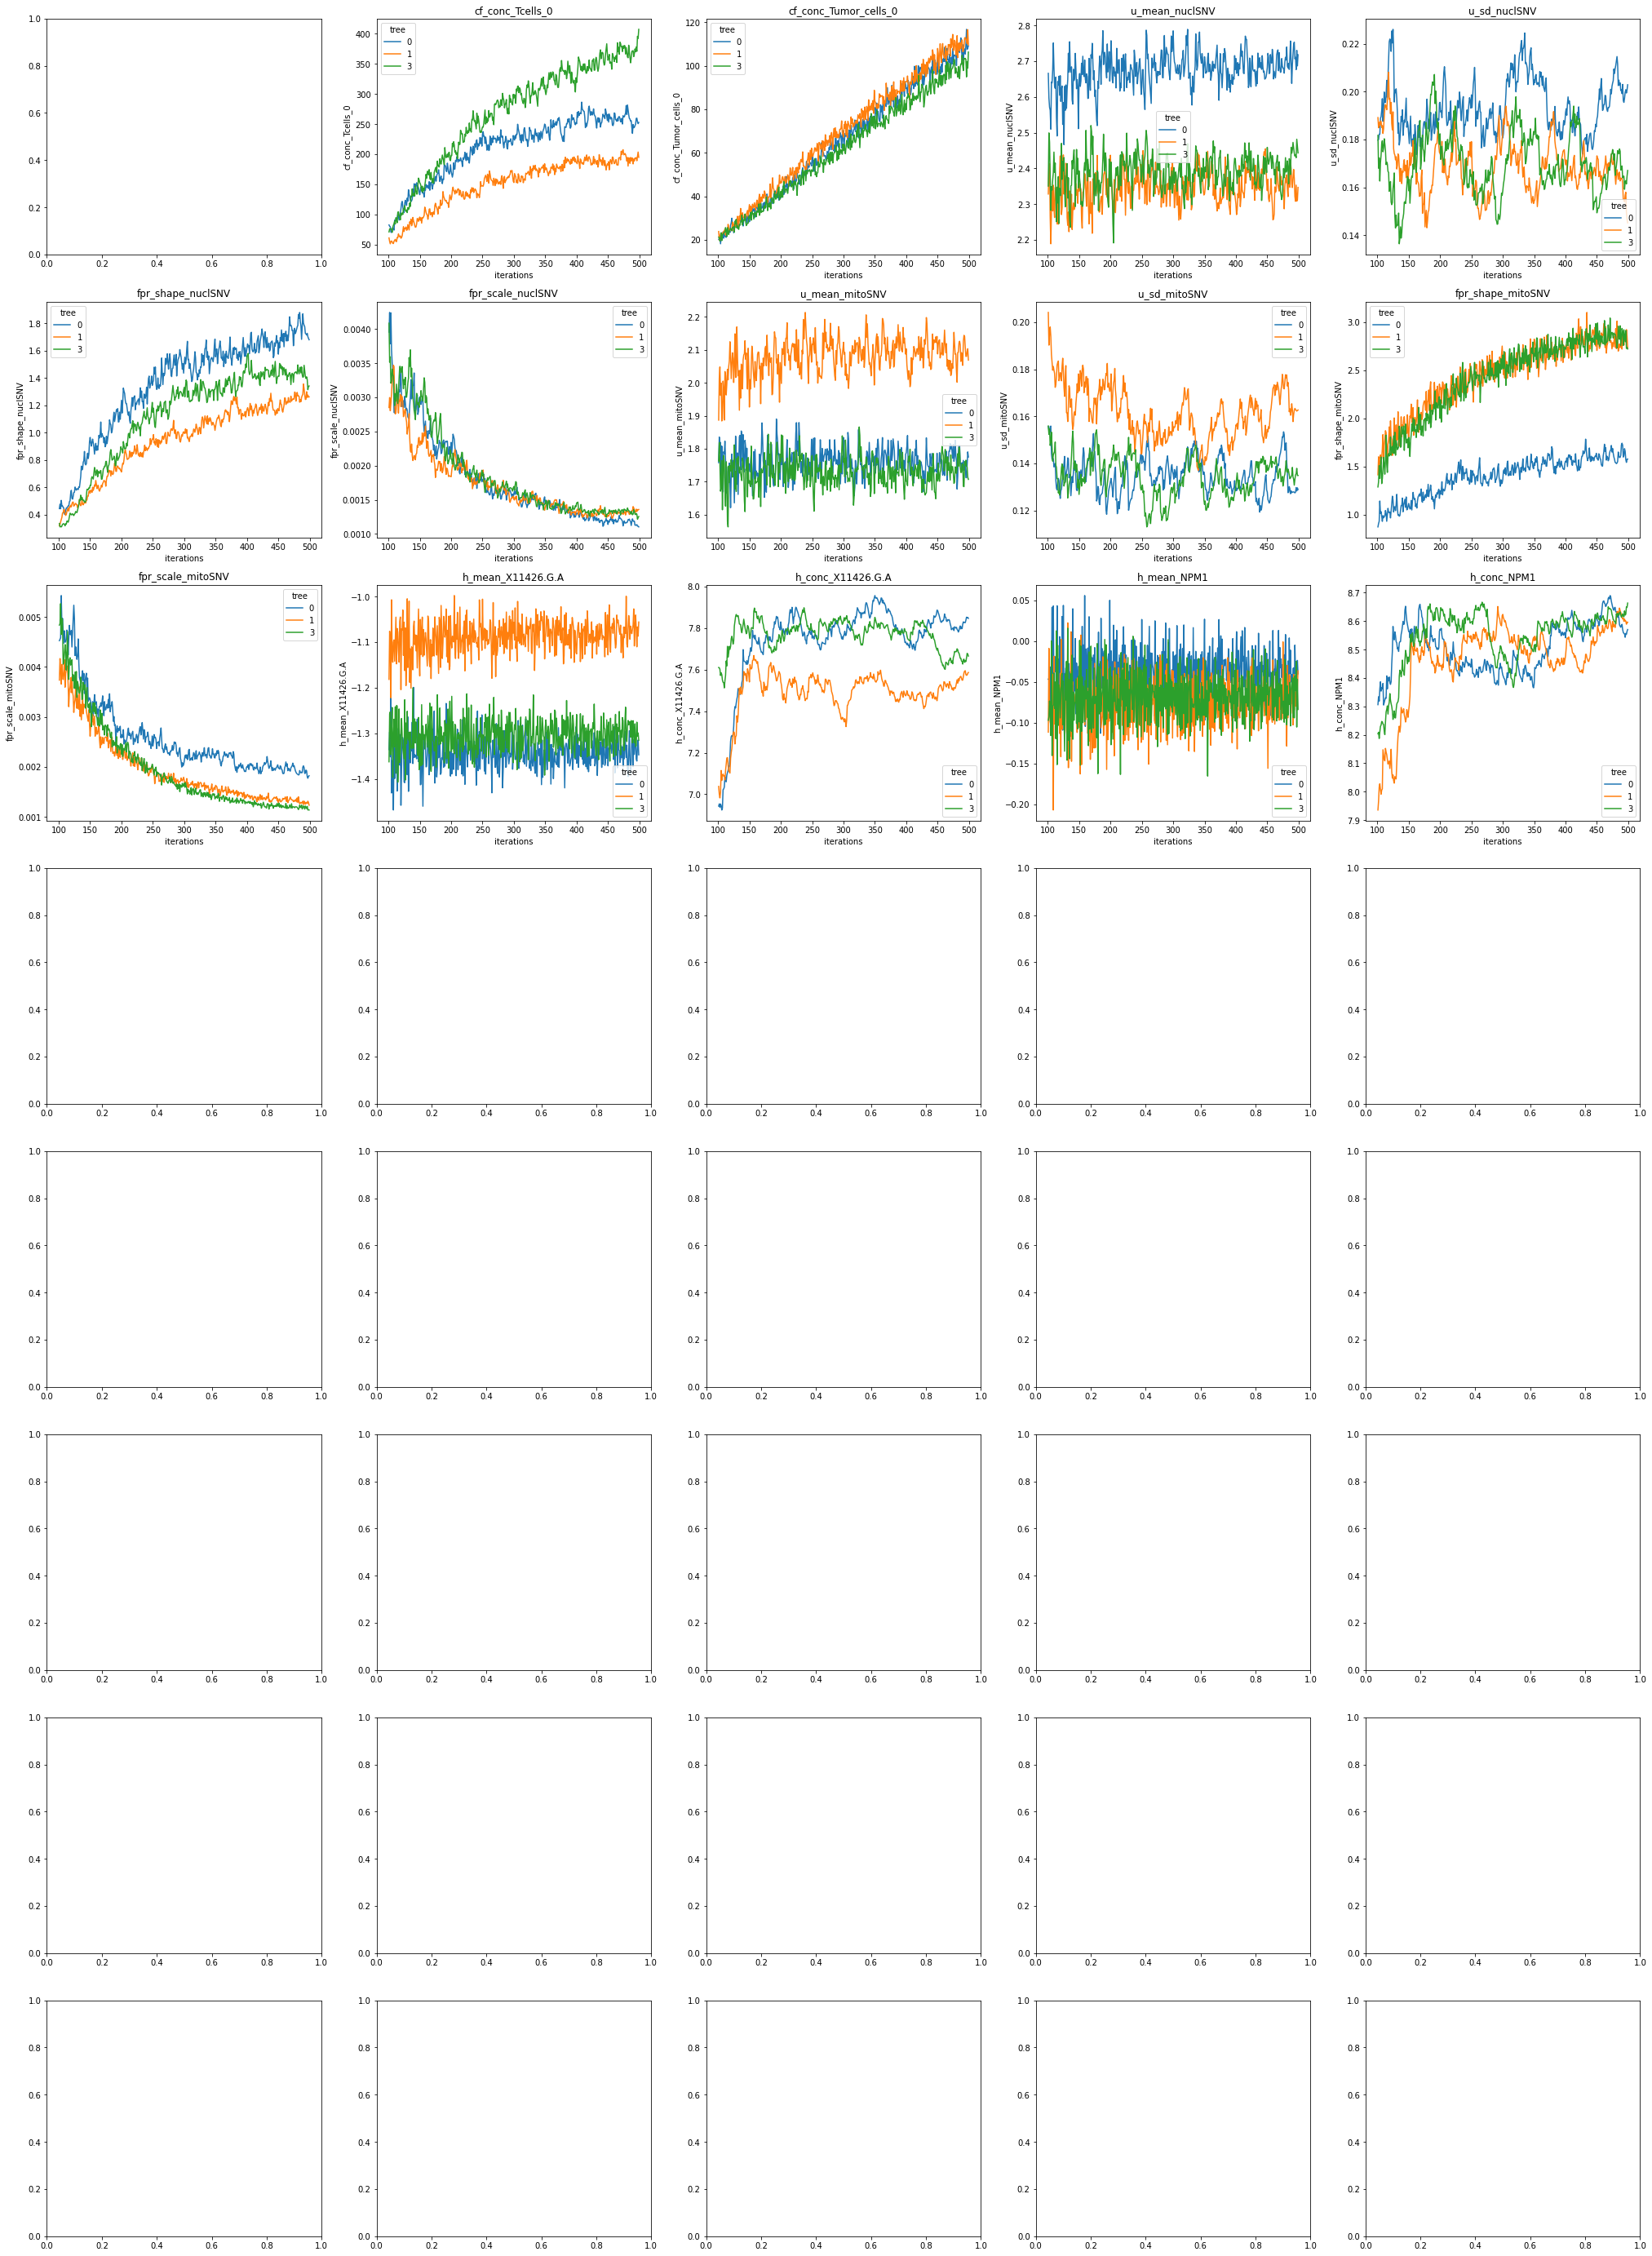

In [24]:
t.print_params(include = t.tree_indices, it = 100)

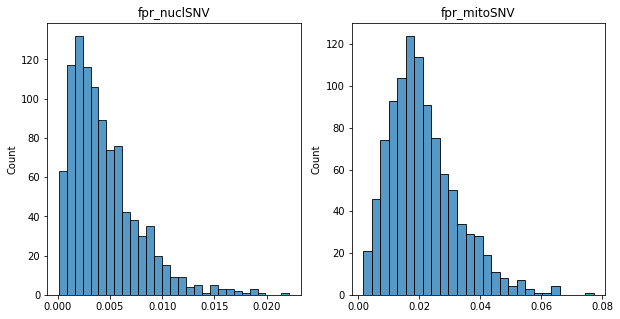

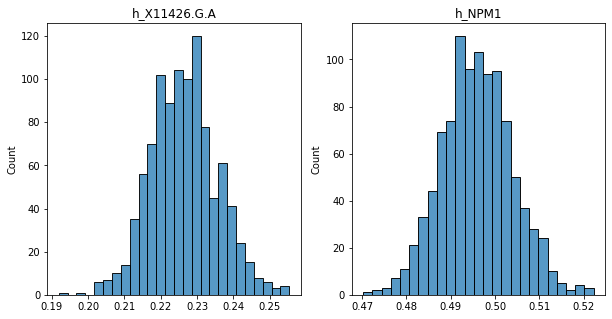

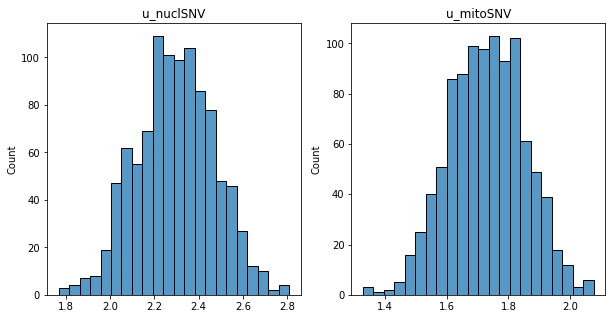

In [21]:
t.plot_posterior("all", 3, 1000)

## Add IDH2

Choosing best tree among 18 potential candidates
Model fit to tree 0 in 1m 40s
Model fit to tree 1 in 1m 40s
Model fit to tree 2 in 1m 39s
Model fit to tree 3 in 1m 40s
Model fit to tree 4 in 1m 40s
Model fit to tree 5 in 1m 39s
Model fit to tree 6 in 1m 39s
Model fit to tree 7 in 1m 39s
Model fit to tree 8 in 1m 38s
Model fit to tree 9 in 1m 38s
Model fit to tree 10 in 1m 39s
Model fit to tree 11 in 1m 40s
Model fit to tree 12 in 1m 42s
Model fit to tree 13 in 1m 40s
Model fit to tree 14 in 1m 40s
Model fit to tree 15 in 1m 39s
Model fit to tree 16 in 1m 43s
Model fit to tree 17 in 1m 46s
Trees [11, 12, 13] selected for mutations ['X11426.G.A', 'NPM1', 'IDH2']
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 1., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
Total run time 0h 30m 9s


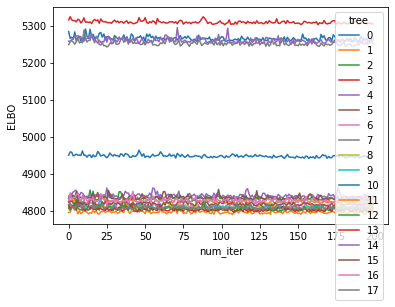

In [31]:
# add mutation and select the best tree(s)
#t.add_mutation()
t.select_tree(num_iter = 400, init = 200)

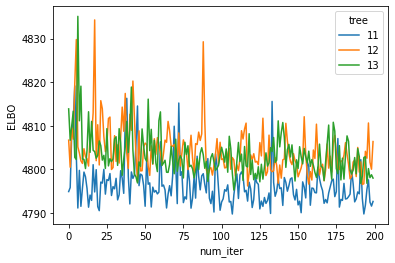

In [32]:
t.print_elbo(num_iter = 400, init = 200, include = t.tree_indices)

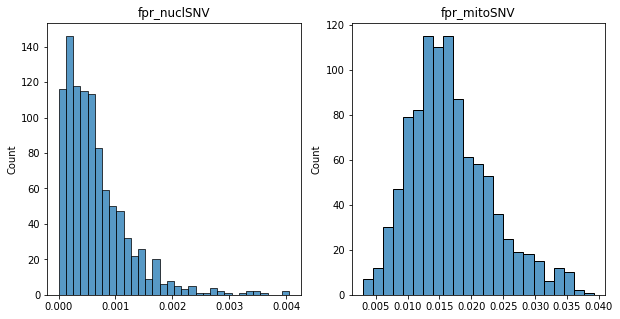

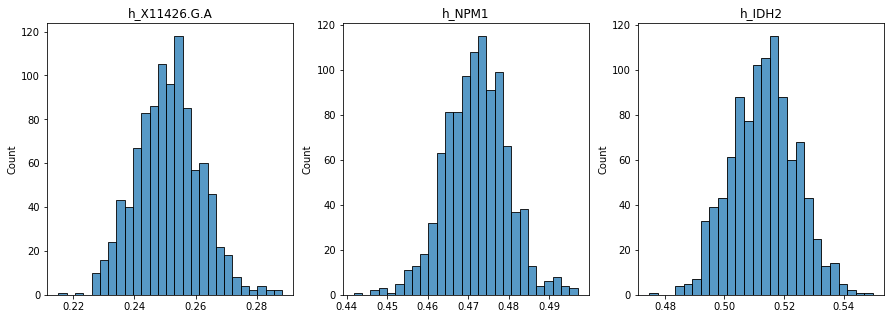

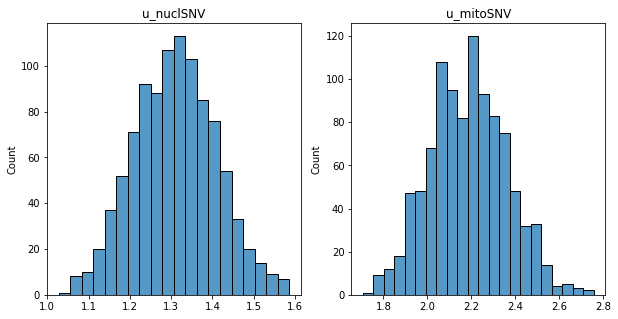

In [33]:
t.plot_posterior(variables = "all", tree = 11)

# Compute clonal assignments

In [34]:
for i in range(len(t.tree_indices)):
    t.clonal_assignment(tree = i)

Computing clonal assignment probabilities for tree 0
Clonal assignment probabilities computed in 1m and 52s
Computing clonal assignment probabilities for tree 1
Clonal assignment probabilities computed in 1m and 52s
Computing clonal assignment probabilities for tree 2
Clonal assignment probabilities computed in 1m and 53s


In [35]:
# export object as pickle
t.export_pickle("svi_objects/"+patient+".pickle")

Tree object saved as pickle!
